In [1]:
file = 'HTML_TEXT/1571225904231.htmlTxt'


In [2]:
with open(file) as handle:
    data = handle.read().splitlines()

In [5]:


import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [44]:
data_blob = '\n'.join(data)
data_blob = data_blob.split('CHAPTER – ')
data_blob = data_blob[1:]

In [48]:

data = data_blob
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]




In [49]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['preliminary', 'short', 'title', 'and', 'commencement', 'these', 'regulations', 'may', 'be', 'called', 'the', 'sebi', 'prohibition', 'of', 'insider', 'trading', 'regulations', 'these', 'regulations', 'shall', 'come', 'into', 'force', 'on', 'the', 'one', 'hundred', 'and', 'twentieth', 'day', 'from', 'the', 'date', 'of', 'its', 'publication', 'in', 'the', 'official', 'gazette', 'definitions', 'in', 'these', 'regulations', 'unless', 'the', 'context', 'otherwise', 'requires', 'the', 'following', 'words', 'expressions', 'and', 'derivations', 'therefrom', 'shall', 'have', 'the', 'meanings', 'assigned', 'to', 'them', 'as', 'under', 'act', 'means', 'the', 'securities', 'and', 'exchange', 'board', 'of', 'india', 'act', 'of', 'board', 'means', 'the', 'securities', 'and', 'exchange', 'board', 'of', 'india', 'compliance', 'officer', 'means', 'any', 'senior', 'officer', 'designated', 'so', 'and', 'reporting', 'to', 'the', 'board', 'of', 'directors', 'or', 'head', 'of', 'the', 'organization', 'in'

In [51]:


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])



In [52]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [53]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[0][:10])

['preliminary', 'short', 'title', 'commencement', 'regulation', 'may', 'call', 'prohibition', 'insider', 'trading']


In [54]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0][:20])



[(0, 1), (1, 11), (2, 1), (3, 1), (4, 1), (5, 2), (6, 4), (7, 1), (8, 1), (9, 2), (10, 1), (11, 2), (12, 2), (13, 2), (14, 2), (15, 1), (16, 1), (17, 1), (18, 4), (19, 1)]


In [55]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [56]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.193907924624006

Coherence Score:  0.30718770565747716


In [57]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/badwolf/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.166449 -0.041219       1        1  34.981239
14    -0.174020  0.074926       2        1  31.634743
9     -0.105466 -0.236398       3        1  20.932861
3     -0.292398  0.083234       4        1  12.420285
8      0.032879  0.002194       5        1   0.001953
2      0.033975  0.013260       6        1   0.001952
17     0.037798  0.010462       7        1   0.001951
13     0.037652  0.002699       8        1   0.001950
6      0.050038  0.008329       9        1   0.001948
16     0.041544  0.007369      10        1   0.001947
4      0.043696  0.007857      11        1   0.001946
11     0.049586  0.006617      12        1   0.001945
7      0.050092  0.007666      13        1   0.001942
18     0.044783  0.004088      14        1   0.001919
15     0.050426  0.008582      15        1   0.001918
0      0.048886  0.004250      16        1   0.001917
5      0.056998  0.008255      17        1   0.001908
12     0.052507  0.006113      18        1   0.001907
19     0.057908  0.011264      19        1   0.001900
10     0.049564  0.010451      20        1   0.001866, topic_info=    Category        Freq          Term       Total  loglift  logprob
131  Default  239.000000   information  239.000000  30.0000  30.0000
235  Default  184.000000         shall  184.000000  29.0000  29.0000
214  Default  161.000000    regulation  161.000000  28.0000  28.0000
723  Default   78.000000     informant   78.000000  27.0000  27.0000
189  Default  109.000000         price  109.000000  26.0000  26.0000
133  Default  121.000000       insider  121.000000  25.0000  25.0000
263  Default  125.000000       trading  125.000000  24.0000  24.0000
262  Default   75.000000         trade   75.000000  23.0000  23.0000
178  Default  133.000000        person  133.000000  22.0000  22.0000
234  Default  103.000000     sensitive  103.000000  21.0000  21.0000
273  Default   90.000000   unpublished   90.000000  20.0000  20.0000
502  Default   51.000000          plan   51.000000  19.0000  19.0000
51   Default   85.000000       company   85.000000  18.0000  18.0000
154  Default   81.000000           may   81.000000  17.0000  17.0000
28   Default   73.000000         board   73.000000  16.0000  16.0000
183  Default   45.000000    possession   45.000000  15.0000  15.0000
229  Default   72.000000      security   72.000000  14.0000  14.0000
196  Default   56.000000       provide   56.000000  13.0000  13.0000
280  Default   50.000000         would   50.000000  12.0000  12.0000
81   Default   49.000000     designate   49.000000  11.0000  11.0000
799  Default   42.000000        reward   42.000000  10.0000  10.0000
145  Default   55.000000          list   55.000000   9.0000   9.0000
362  Default   56.000000    disclosure   56.000000   8.0000   8.0000
47   Default   43.000000          code   43.000000   7.0000   7.0000
52   Default   41.000000    compliance   41.000000   6.0000   6.0000
332  Default   43.000000       conduct   43.000000   5.0000   5.0000
149  Default   33.000000          make   33.000000   4.0000   4.0000
553  Default   34.000000           sub   34.000000   3.0000   3.0000
444  Default   35.000000           law   35.000000   2.0000   2.0000
168  Default   37.000000       officer   37.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
81   Topic20    0.000152     designate   49.354927  -1.8032  -6.7135
47   Topic20    0.000149          code   43.353142  -1.6939  -6.7338
189  Topic20    0.000156         price  109.602234  -2.5745  -6.6869
133  Topic20    0.000157       insider  121.487770  -2.6724  -6.6819
332  Topic20    0.000146       conduct   43.383686  -1.7152  -6.7544
51   Topic20    0.000150       company   85.056099  -2.3615  -6.7274
273  Topic20    0.000146   unpublished   90.089096  -2.4444  -6.7529
220  Topic20    0.000140       require   40.546356  -1.6861  -6.7929
234  Topi

In [58]:
mallet_path = "/home/badwolf/Downloads/mallet-2.0.8/bin/mallet" # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)


In [59]:


# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)



[(2,
  [('regulation', 0.17008797653958943),
   ('conduct', 0.12903225806451613),
   ('code', 0.12903225806451613),
   ('compliance', 0.12609970674486803),
   ('require', 0.07038123167155426),
   ('basis', 0.05278592375366569),
   ('organisation', 0.026392961876832845),
   ('assist', 0.020527859237536656),
   ('practice', 0.020527859237536656),
   ('procedure', 0.020527859237536656)]),
 (4,
  [('violation', 0.1095890410958904),
   ('report', 0.1095890410958904),
   ('case', 0.0684931506849315),
   ('issue', 0.0593607305936073),
   ('document', 0.0593607305936073),
   ('employee', 0.0502283105022831),
   ('determine', 0.0410958904109589),
   ('complete', 0.0410958904109589),
   ('expect', 0.0228310502283105),
   ('discharge', 0.0228310502283105)]),
 (11,
  [('insider', 0.26024096385542167),
   ('information', 0.1614457831325301),
   ('make', 0.0819277108433735),
   ('purpose', 0.05783132530120482),
   ('share', 0.03855421686746988),
   ('individual', 0.03132530120481928),
   ('receipt',

In [60]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [61]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

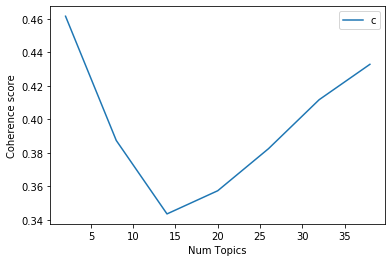

In [62]:


limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



In [63]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4615
Num Topics = 8  has Coherence Value of 0.3873
Num Topics = 14  has Coherence Value of 0.3434
Num Topics = 20  has Coherence Value of 0.3573
Num Topics = 26  has Coherence Value of 0.3824
Num Topics = 32  has Coherence Value of 0.4117
Num Topics = 38  has Coherence Value of 0.4328


In [67]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.144*"informant" + 0.078*"reward" + 0.048*"original" + 0.046*"form" + '
  '0.043*"voluntary" + 0.034*"submit" + 0.034*"law" + 0.034*"violation" + '
  '0.027*"action" + 0.021*"identity"'),
 (1,
  '0.295*"information" + 0.224*"regulation" + 0.044*"include" + 0.033*"case" + '
  '0.030*"relate" + 0.021*"follow" + 0.021*"issue" + 0.020*"legal" + '
  '0.015*"receipt" + 0.014*"deem"'),
 (2,
  '0.067*"code" + 0.053*"provision" + 0.049*"price" + 0.049*"conduct" + '
  '0.046*"employee" + 0.035*"market" + 0.035*"intermediary" + '
  '0.035*"unpublished" + 0.030*"list" + 0.030*"firm"'),
 (3,
  '0.086*"make" + 0.073*"time" + 0.063*"security" + 0.045*"purpose" + '
  '0.045*"decision" + 0.045*"period" + 0.040*"share" + 0.038*"transaction" + '
  '0.025*"pursuant" + 0.025*"accordance"'),
 (4,
  '0.126*"price" + 0.121*"plan" + 0.102*"possession" + 0.078*"sensitive" + '
  '0.071*"unpublished" + 0.059*"information" + 0.029*"unpublishe" + '
  '0.026*"intend" + 0.021*"entail" + 0.017*"enable"'),
 (5

In [68]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.2145,"intend, employee, define, public, hold, act, t...",I PRELIMINARY Short title and commencement. Th...
1,1,4.0,0.2601,"price, plan, possession, sensitive, unpublishe...",II RESTRICTIONS ON COMMUNICATION AND TRADING B...
2,2,6.0,0.3677,"disclosure, person, trading, security, day, di...",III DISCLOSURES OF TRADING BY INSIDERS General...
3,3,0.0,0.3126,"informant, reward, original, form, voluntary, ...","IIIA Definitions. A. (1) In this Chapter, unle..."
4,4,2.0,0.3813,"code, provision, price, conduct, employee, mar...",IV CODES OF FAIR DISCLOSURE AND CONDUCT Code o...
5,5,7.0,0.1520,"conduct, code, board, application, detail, sta...",V MISCELLANEOUS Sanction for violations. 0.Any...


In [69]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,8.0,"intend, employee, define, public, hold, act, t...",1.0,0.1667
1.0,4.0,"price, plan, possession, sensitive, unpublishe...",NaN,NaN
2.0,6.0,"disclosure, person, trading, security, day, di...",1.0,0.1667
3.0,0.0,"informant, reward, original, form, voluntary, ...",NaN,NaN
4.0,2.0,"code, provision, price, conduct, employee, mar...",1.0,0.1667
5.0,7.0,"conduct, code, board, application, detail, sta...",NaN,NaN
6.0,NaN,NaN,1.0,0.1667
7.0,NaN,NaN,1.0,0.1667
8.0,NaN,NaN,1.0,0.1667


In [97]:
df_dominant_topic.to_csv('insiderTradingPerChapterTopic.csv')
df_dominant_topics.to_csv('insiderTradingPerChapterTopics.csv')

In [106]:
import os
data = []
file_path = "./HTML_TEXT/"
files = os.listdir(file_path)


In [107]:
files = [i for i in files if (i[-3:]=="Txt" )]

In [108]:
for file in files:
    file_name = file_path+file
    data.append(open(file_name).read())

In [109]:

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]




In [110]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))


In [111]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [112]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [113]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [114]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [116]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.241518001980695

Coherence Score:  0.3451469373657729


In [117]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/badwolf/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.100031 -0.053440       1        1  21.910961
18    -0.155517 -0.053299       2        1  17.974325
0     -0.125757 -0.070952       3        1  17.292248
16    -0.142343  0.044199       4        1  11.446679
6     -0.146347  0.047183       5        1   8.829498
11    -0.075919  0.069587       6        1   8.395778
13    -0.095584  0.111577       7        1   4.696838
17    -0.159079 -0.042823       8        1   4.133719
3     -0.126315  0.037617       9        1   2.351156
14    -0.119937 -0.132650      10        1   1.881409
19    -0.060697  0.101860      11        1   1.084722
10     0.098077 -0.028621      12        1   0.000312
9      0.103657 -0.014248      13        1   0.000310
8      0.121857 -0.004433      14        1   0.000307
1      0.108740 -0.020014      15        1   0.000306
2      0.149938 -0.007320      16        1   0.000292
12     0.166115  0.000075      17        1   0.000292
4      0.161547  0.006049      18        1   0.000286
15     0.184250  0.005229      19        1   0.000286
7      0.213345  0.004426      20        1   0.000285, topic_info=     Category         Freq            Term        Total  loglift  logprob
496   Default  4817.000000           shall  4817.000000  30.0000  30.0000
448   Default  3924.000000      regulation  3924.000000  29.0000  29.0000
285   Default  1584.000000            list  1584.000000  28.0000  28.0000
1185  Default  1518.000000      investment  1518.000000  27.0000  27.0000
679   Default   965.000000          entity   965.000000  26.0000  26.0000
343   Default  1104.000000           offer  1104.000000  25.0000  25.0000
822   Default  1151.000000           share  1151.000000  24.0000  24.0000
88    Default  1271.000000         company  1271.000000  23.0000  23.0000
263   Default  1268.000000           issue  1268.000000  22.0000  22.0000
484   Default  1424.000000        security  1424.000000  21.0000  21.0000
301   Default  1579.000000             may  1579.000000  20.0000  20.0000
52    Default  1386.000000           board  1386.000000  19.0000  19.0000
1478  Default   676.000000           trust   676.000000  18.0000  18.0000
1538  Default   922.000000       amendment   922.000000  17.0000  17.0000
1075  Default   849.000000        exchange   849.000000  16.0000  16.0000
1441  Default   921.000000           stock   921.000000  15.0000  15.0000
296   Default   812.000000         manager   812.000000  14.0000  14.0000
699   Default   690.000000            fund   690.000000  13.0000  13.0000
2269  Default   643.000000      depository   643.000000  12.0000  12.0000
506   Default  1213.000000         specify  1213.000000  11.0000  11.0000
421   Default  1117.000000         provide  1117.000000  10.0000  10.0000
1165  Default   459.000000  infrastructure   459.000000   9.0000   9.0000
660   Default   863.000000        director   863.000000   8.0000   8.0000
3563  Default   356.000000           invit   356.000000   7.0000   7.0000
521   Default   865.000000             sub   865.000000   6.0000   6.0000
378   Default   981.000000          person   981.000000   5.0000   5.0000
294   Default   897.000000            make   897.000000   4.0000   4.0000
246   Default   842.000000     information   842.000000   3.0000   3.0000
424   Default   660.000000          public   660.000000   2.0000   2.0000
1098  Default   534.000000       financial   534.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
496   Topic20     0.000580           shall  4817.773438  -3.1636  -6.4832
484   Topic20     0.000375        security  1424.592896  -2.3829  -6.9209
1075  Topic20     0.000329        exchange   849.948669  -1.9968  -7.0513
52    Topic20     0.000353           board  1386.180664  -2.4151  -6.9805
1441  Topic20     0.000304           stock   921.636108  -2.1553  -7.1288
246   Topic20     0.000277     

In [118]:
mallet_path = "/home/badwolf/Downloads/mallet-2.0.8/bin/mallet" # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [119]:
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(15,
  [('entity', 0.15840805411357559),
   ('director', 0.05364165486864873),
   ('financial', 0.042158250747207804),
   ('report', 0.034764826175869123),
   ('list', 0.03114676734308636),
   ('security', 0.02737140160453044),
   ('obligation', 0.02705678779298411),
   ('audit', 0.018404907975460124),
   ('debt', 0.018090294163913796),
   ('information', 0.01793298725814063)]),
 (9,
  [('investor', 0.06125258086717137),
   ('officer', 0.04611149346180317),
   ('administrator', 0.03716448726772195),
   ('recovery', 0.03372333103922918),
   ('refund', 0.03234686854783207),
   ('monie', 0.030282174810736407),
   ('property', 0.02477632484514797),
   ('sale', 0.02477632484514797),
   ('claim', 0.02477632484514797),
   ('process', 0.022711631108052306)]),
 (8,
  [('fund', 0.16994106090373282),
   ('investment', 0.10379829731499672),
   ('alternative', 0.0618860510805501),
   ('company', 0.032089063523248196),
   ('category', 0.029142108709888672),
   ('regulation', 0.027832351015062214),


In [120]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

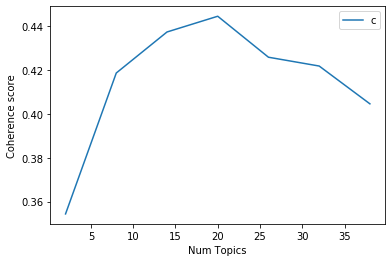

In [121]:


limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



In [122]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3544
Num Topics = 8  has Coherence Value of 0.4187
Num Topics = 14  has Coherence Value of 0.4374
Num Topics = 20  has Coherence Value of 0.4446
Num Topics = 26  has Coherence Value of 0.4259
Num Topics = 32  has Coherence Value of 0.4219
Num Topics = 38  has Coherence Value of 0.4046


In [123]:


optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))



[(0,
  '0.097*"company" + 0.055*"scheme" + 0.055*"employee" + 0.038*"share" + '
  '0.025*"benefit" + 0.024*"grant" + 0.024*"option" + 0.022*"part" + '
  '0.022*"trust" + 0.020*"exercise"'),
 (1,
  '0.119*"list" + 0.100*"entity" + 0.035*"director" + 0.026*"financial" + '
  '0.020*"stock" + 0.018*"report" + 0.018*"obligation" + 0.017*"result" + '
  '0.016*"disclosure" + 0.015*"requirement"'),
 (2,
  '0.078*"information" + 0.039*"person" + 0.032*"trading" + 0.031*"sensitive" '
  '+ 0.028*"trade" + 0.020*"informant" + 0.020*"plan" + 0.020*"company" + '
  '0.016*"possession" + 0.015*"designate"'),
 (3,
  '0.073*"company" + 0.056*"security" + 0.041*"board" + 0.027*"director" + '
  '0.025*"public" + 0.021*"resolution" + 0.021*"amount" + 0.017*"case" + '
  '0.017*"market" + 0.015*"provision"'),
 (4,
  '0.130*"regulation" + 0.067*"provide" + 0.041*"make" + 0.040*"include" + '
  '0.022*"period" + 0.022*"purpose" + 0.017*"year" + 0.016*"account" + '
  '0.015*"person" + 0.014*"date"'),
 (5,
  '0.1

In [124]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.7585,"officer, authorise, person, search, document, ...",THE GAZETTE OF INDIA EXTRAORDINARY PART III – ...
1,1,14.0,0.5244,"investor, administrator, recovery, claim, offi...",THE GAZETTE OF INDIA EXTRAORDINARY PART III - ...
2,2,12.0,0.5686,"settlement, applicant, proceeding, application...",GAZETTE OF INDIA EXTRAORDINARY PART – III – SE...
3,3,2.0,0.5278,"information, person, trading, sensitive, trade...",THE GAZETTE OF INDIA EXTRAORDINARY PART – III ...
4,4,8.0,0.3902,"portfolio, manager, client, investment, page, ...",THE GAZETTE OF INDIA EXTRAORDINARY PART III – ...
5,5,7.0,0.5497,"offer, share, regulation, company, open, targe...",THE GAZETTE OF INDIA EXTRAORDINARY PART – III ...
6,6,13.0,0.3045,"regulation, board, information, act, case, per...",THE GAZETTE OF INDIA EXTRAORDINARY PART – III ...
7,7,10.0,0.5344,"recognise, stock, exchange, director, member, ...",THE GAZETTE OF INDIA EXTRAORDINARY PART III - ...
8,8,16.0,0.6177,"investment, trust, amendment, regulation, mana...",THE GAZETTE OF INDIA EXTRAORDINARY PART – III ...
9,9,6.0,0.5136,"fund, investment, alternative, category, compa...",THE GAZETTE OF INDIA EXTRAORDINARY PART – III ...


In [125]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,17.0,"officer, authorise, person, search, document, ...",2.0,0.0952
1,14.0,"investor, administrator, recovery, claim, offi...",1.0,0.0476
2,12.0,"settlement, applicant, proceeding, application...",1.0,0.0476
3,2.0,"information, person, trading, sensitive, trade...",1.0,0.0476
4,8.0,"portfolio, manager, client, investment, page, ...",NaN,NaN
5,7.0,"offer, share, regulation, company, open, targe...",2.0,0.0952
6,13.0,"regulation, board, information, act, case, per...",1.0,0.0476
7,10.0,"recognise, stock, exchange, director, member, ...",1.0,0.0476
8,16.0,"investment, trust, amendment, regulation, mana...",1.0,0.0476
9,6.0,"fund, investment, alternative, category, compa...",2.0,0.0952


In [126]:
df_dominant_topic.to_csv('allDocumentTopic.csv')
df_dominant_topics.to_csv('allDocumentTopics.csv')